## Comparing tree height measured from the ground to a Lidar-based Canopy Height Model

This exercise uses the Canopy Height Model (CHM) and vegetation structure data from Wind River Experimental Forest in Washington State.

Start by loading packages and setting options. Note that I've suppressed warnings to make this notebook look nice, but in your own workspace it's generally helpful to have the warnings.

In [2]:
options(stringsAsFactors = F, warn = -1)
library(raster)
library(neonUtilities)
library(geoNEON)

### 1. Vegetation structure data

Download and stack the vegetation structure data, if you haven't done that yet:

In [ ]:
zipsByProduct(dpID="DP1.10098.001", site="WREF", package="basic", 
              savepath="/data")
stackByTable("/data/filesToStack10098", folder=T)

Read the vegetation mapping data (mappingandtagging) and annual measurements (apparentindividuals) into the environment.

In [ ]:
vegmap <- read.delim("/data/filesToStack10098/stackedFiles/vst_mappingandtagging.csv",
                     sep=",")
vegind <- read.delim("/data/filesToStack10098/stackedFiles/vst_apparentindividual.csv",
                     sep=",")

Use the `geoNEON` package to get precise locations for the tagged plants, then merge the mapping and annual measurements tables.

In [ ]:
vegmap <- def.calc.geo.os(vegmap, "vst_mappingandtagging")
veg <- merge(vegind, vegmap, by=c("individualID","namedLocation",
                                  "domainID","siteID","plotID"))

Let's see what the data look like! Pick a plot, and make a stem map of the plants in it. Note that stemDiameter is in centimeters.

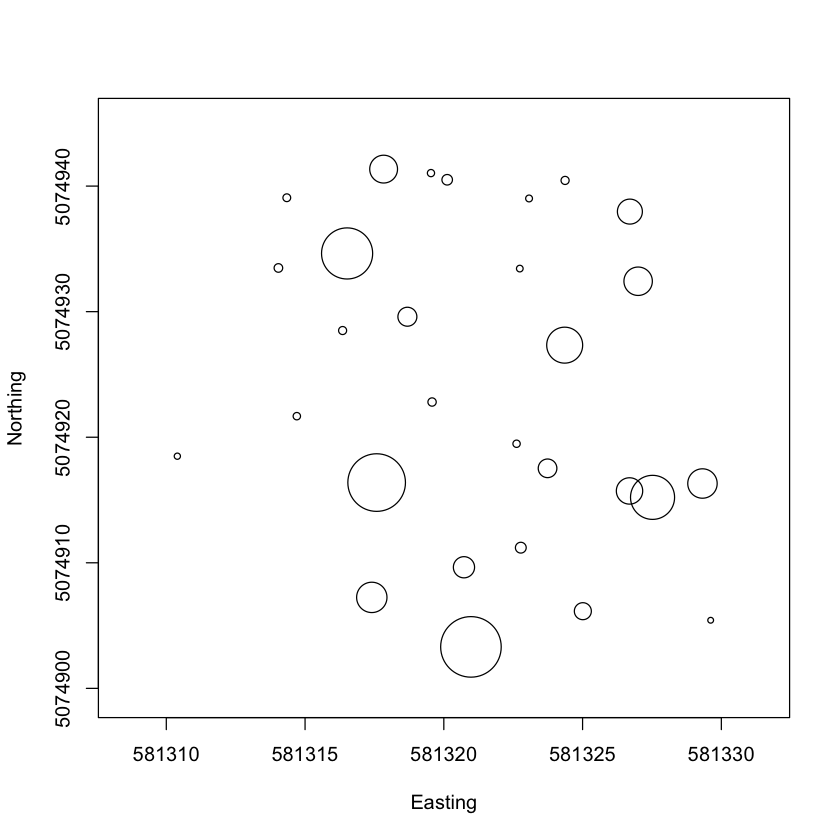

In [4]:
symbols(veg$adjEasting[which(veg$plotID=="WREF_081")], 
        veg$adjNorthing[which(veg$plotID=="WREF_081")], 
        circles=veg$stemDiameter[which(veg$plotID=="WREF_081")]/100, 
        inches=F, xlab="Easting", ylab="Northing")

And now overlay the estimated uncertainty in the location of each stem, in blue:

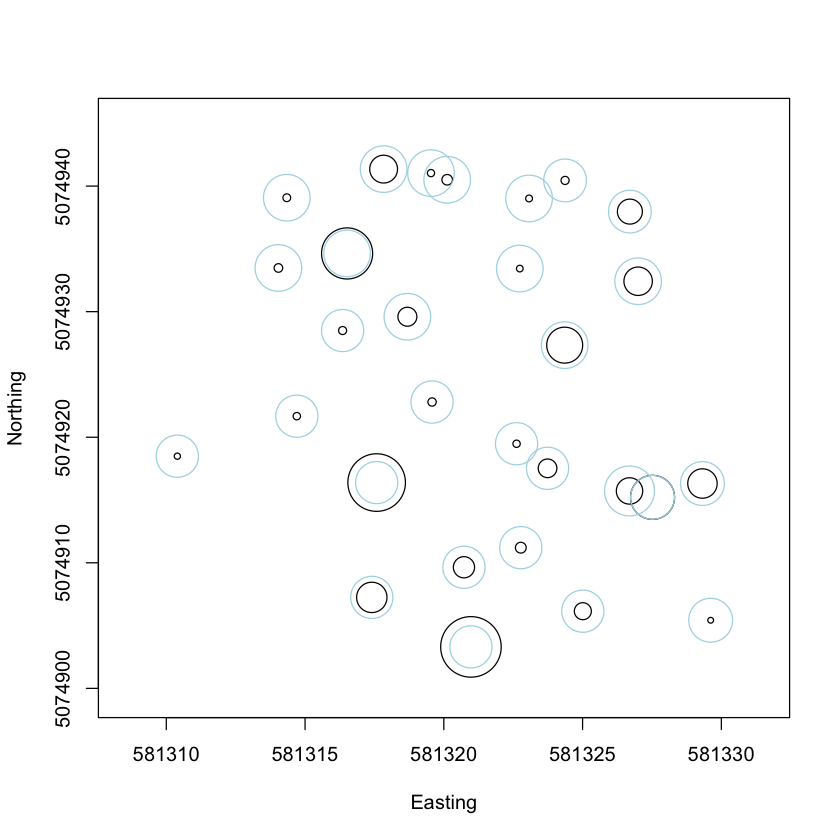

In [5]:
symbols(veg$adjEasting[which(veg$plotID=="WREF_081")], 
        veg$adjNorthing[which(veg$plotID=="WREF_081")], 
        circles=veg$stemDiameter[which(veg$plotID=="WREF_081")]/100, 
        inches=F, xlab="Easting", ylab="Northing")
symbols(veg$adjEasting[which(veg$plotID=="WREF_081")], 
        veg$adjNorthing[which(veg$plotID=="WREF_081")], 
        circles=veg$adjCoordinateUncertainty[which(veg$plotID=="WREF_081")], 
        inches=F, add=T, fg="lightblue")

### 2. Canopy height model data

Download the CHM tile from the data portal, if you haven't done that yet. Note that in this exercise we're using a single tile, to limit the download volume. To evaluate the whole site, you'd need to download all the tiles.

Load the tile into the environment using the `raster` package.

In [ ]:
chm <- raster('/data/NEON_D16_WREF_DP3_580000_5075000_CHM.tif')

Let's view the tile:

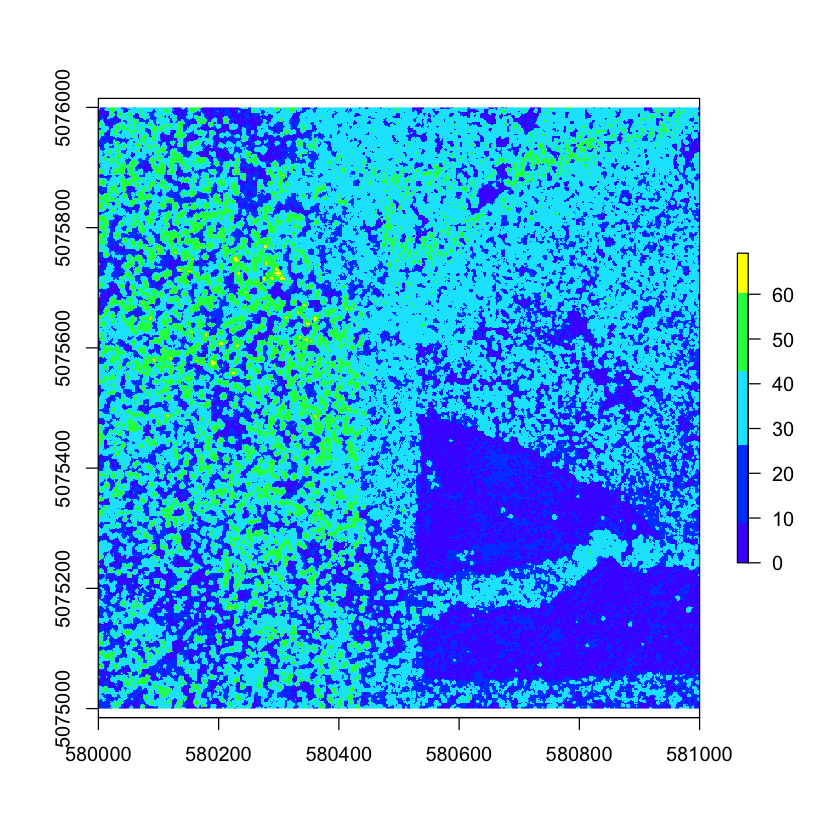

In [7]:
plot(chm, col=topo.colors(5))

### 3. Comparing the two datasets

First, subset the veg structure data to only the individuals that fall within this tile, using the `extent()` function from the raster package.

In [23]:
vegsub <- veg[which(veg$adjEasting >= extent(chm)[1] &
                      veg$adjEasting <= extent(chm)[2] &
                      veg$adjNorthing >= extent(chm)[3] & 
                      veg$adjNorthing <= extent(chm)[4]),]

There are many different ways to approach this comparison! Let's do a very simple first pass: use the `extract()` function from the raster package to get the CHM value matching the coordinates of each mapped plant. Include a buffer equal to the uncertainty in the plant's location, and take the highest value within the buffer.

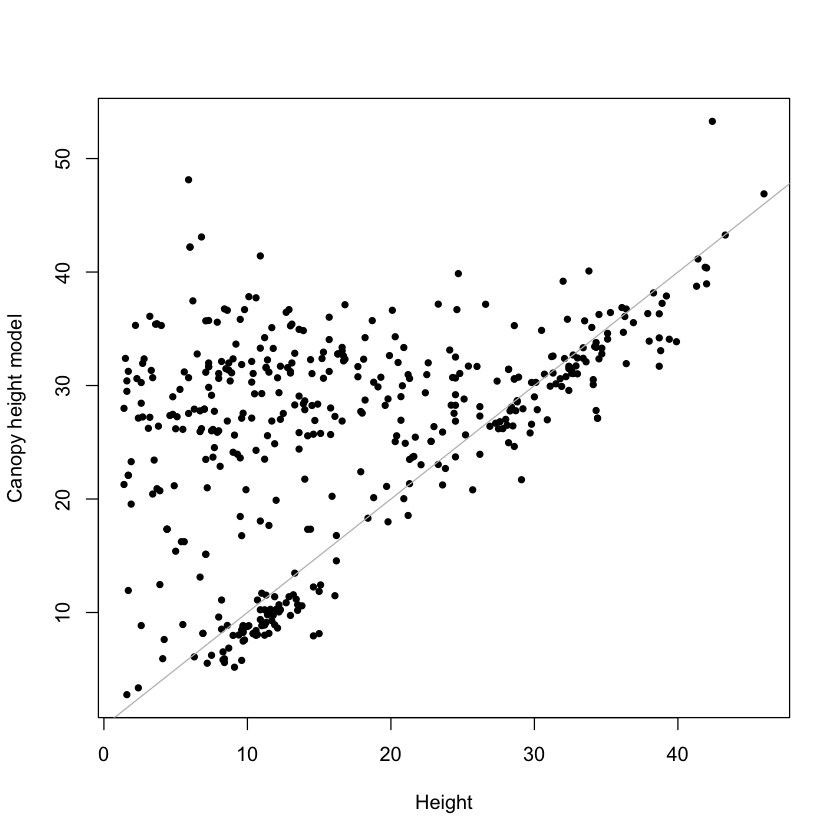

In [9]:
bufferCHM <- extract(chm, cbind(vegsub$adjEasting, vegsub$adjNorthing),
                         buffer=vegsub$adjCoordinateUncertainty, fun=max)
plot(bufferCHM~vegsub$height, pch=20, xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [10]:
cor(bufferCHM,vegsub$height, use="complete")

[1] 0.4289529

There are a lot of points clustered on the 1-1 line, but there is also a cloud of points above the line, where the measured height is lower than the canopy height model at the same coordinates. This makes sense, because we made no attempt to filter out the understory. There are likely many plants measured in the veg structure data that are not at the top of the canopy, and the CHM sees only the top of the canopy.

How to exclude understory plants from this analysis? Again, there are many possible approaches. I'll show two here, one map-centric and one tree-centric.

Starting with the map-centric approach: select a pixel size, and aggregate both the veg structure data and the CHM data to find the tallest point in each pixel. Let's try this with 10m pixels.

Start by rounding the coordinates of the veg structure data, to create 10m bins. Use `floor()` instead of `round()` so each tree ends up in the pixel with the same numbering as the raster pixels.

In [24]:
easting10 <- 10*floor(vegsub$adjEasting/10)
northing10 <- 10*floor(vegsub$adjNorthing/10)
vegsub <- cbind(vegsub, easting10, northing10)

Use the `aggregate()` function to get the tallest tree in each 10m bin.

In [25]:
vegbin <- stats::aggregate(vegsub, by=list(vegsub$easting10, vegsub$northing10), FUN=max)

To get the CHM values for the 10m bins, use the `raster` package version of the `aggregate()` function.

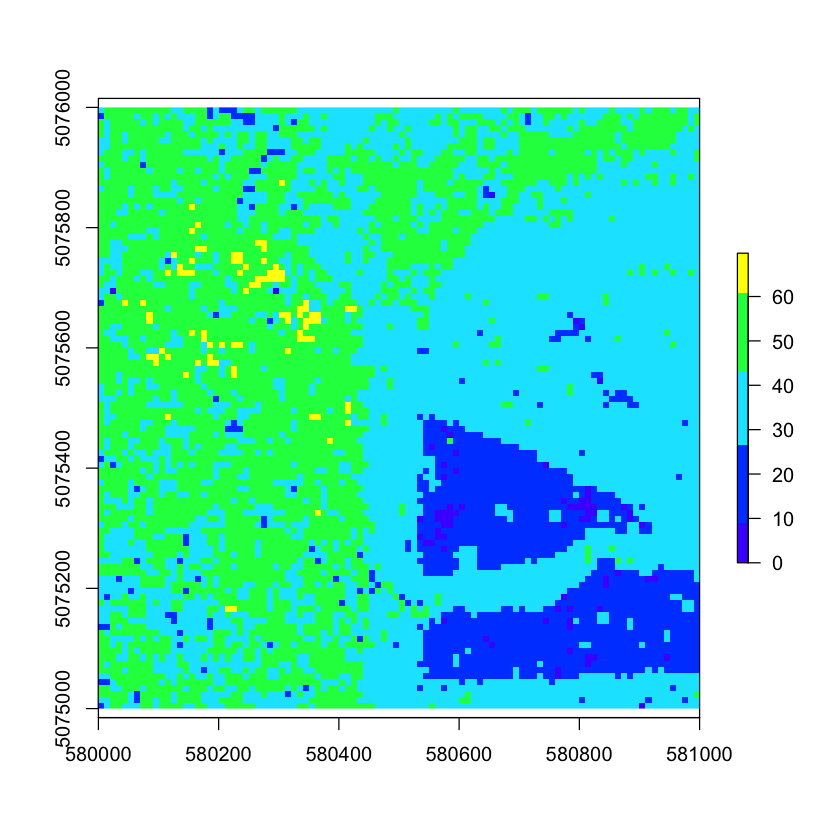

In [13]:
CHM10 <- raster::aggregate(chm, fact=10, fun=max)
plot(CHM10, col=topo.colors(5))

Use the `extract()` function again to get the values from each pixel. We don't need a buffer this time, since we've put both datasets onto the same grid. But our grids are numbered by the corners, so add 5 to each tree coordinate to make sure it's in the correct pixel.

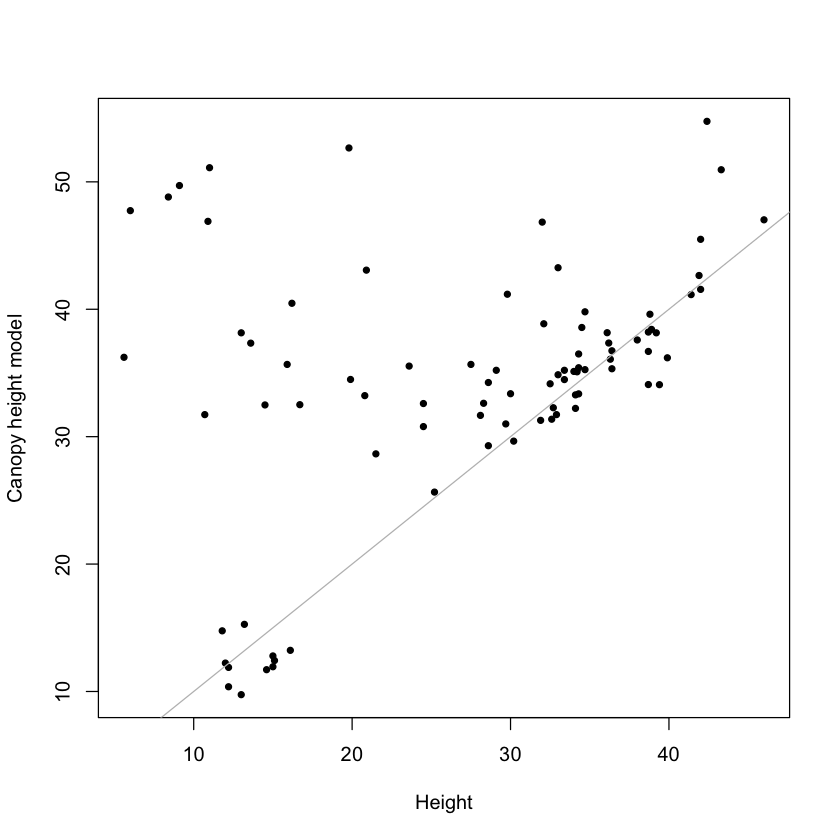

In [26]:
vegbin$easting10 <- vegbin$easting10+5
vegbin$northing10 <- vegbin$northing10+5
binCHM <- extract(CHM10, cbind(vegbin$easting10, vegbin$northing10))
plot(binCHM~vegbin$height, pch=20, xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [27]:
cor(binCHM, vegbin$height, use="complete")

[1] 0.3830575

The understory points are thinned out substantially, but so are the rest - we've lost a lot of data by going to a lower resolution.

Let's try and see if we can identify the tallest trees by another approach, using the trees as the starting point instead of map area. Start by sorting the veg structure data by height.

In [28]:
vegsub <- vegsub[order(vegsub$height, decreasing=T),]

Now, for each tree, let's estimate which nearby trees might be beneath its canopy, and discard those points. To do this:
1. Calculate the distance of each tree from the target tree.
2. Pick a reasonable estimate for canopy size, and discard shorter trees within that radius. The radius I used is 0.3 times the height, based on some rudimentary googling about Douglas fir allometry. It could definitely be improved on!
3. Iterate over all trees.

In [29]:
vegfil <- vegsub
for(i in 1:nrow(vegsub)) {
    if(is.na(vegfil$height[i]))
        next
    dist <- sqrt((vegsub$adjEasting[i]-vegsub$adjEasting)^2 + 
                (vegsub$adjNorthing[i]-vegsub$adjNorthing)^2)
    vegfil$height[which(dist<0.3*vegsub$height[i] & vegsub$height<vegsub$height[i])] <- NA
}

vegfil <- vegfil[which(!is.na(vegfil$height)),]

Now extract the raster values, as above. Let's also increase the buffer size a bit, to better account for the uncertainty in the Lidar data as well as the uncertainty in the ground locations.

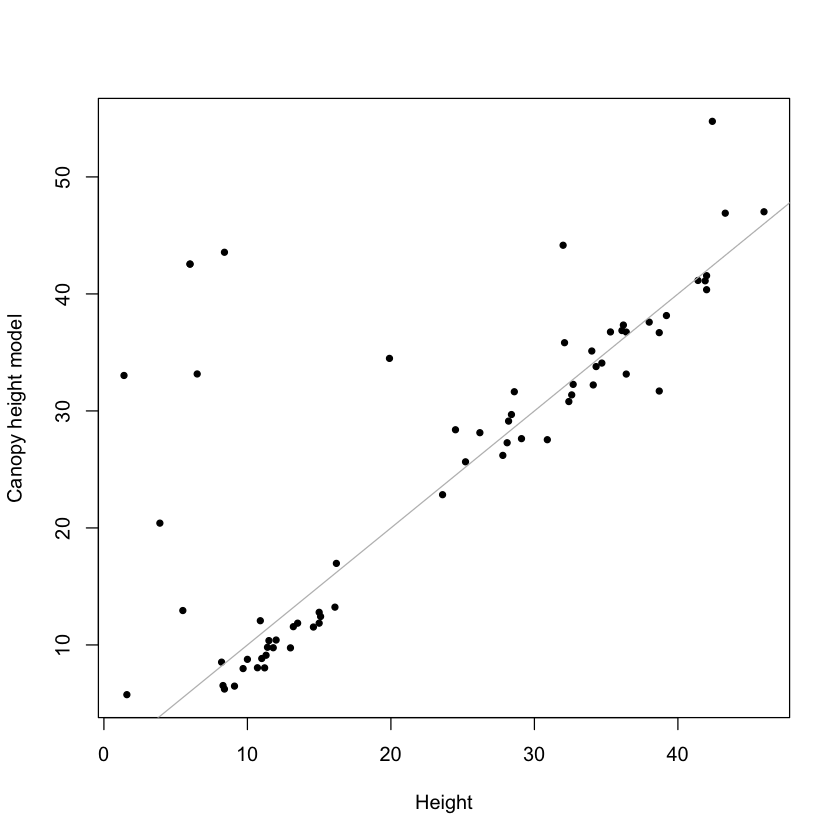

In [30]:
filterCHM <- extract(chm, cbind(vegfil$adjEasting, vegfil$adjNorthing),
                         buffer=vegfil$adjCoordinateUncertainty+1, fun=max)
plot(filterCHM~vegfil$height, pch=20, xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [31]:
cor(filterCHM,vegfil$height)

[1] 0.7365037

This is quite a bit better! There are still several understory points we failed to exclude, but we were able to filter out most of the understory without losing so many overstory points.

Let's try one last thing. The `plantStatus` field in the veg structure data indicates whether a plant is dead, broken, or otherwise damaged. In theory, a dead or broken tree can still be the tallest thing around, but it's less likely, and it's also less likely to get a good Lidar return. Exclude all trees that aren't alive:

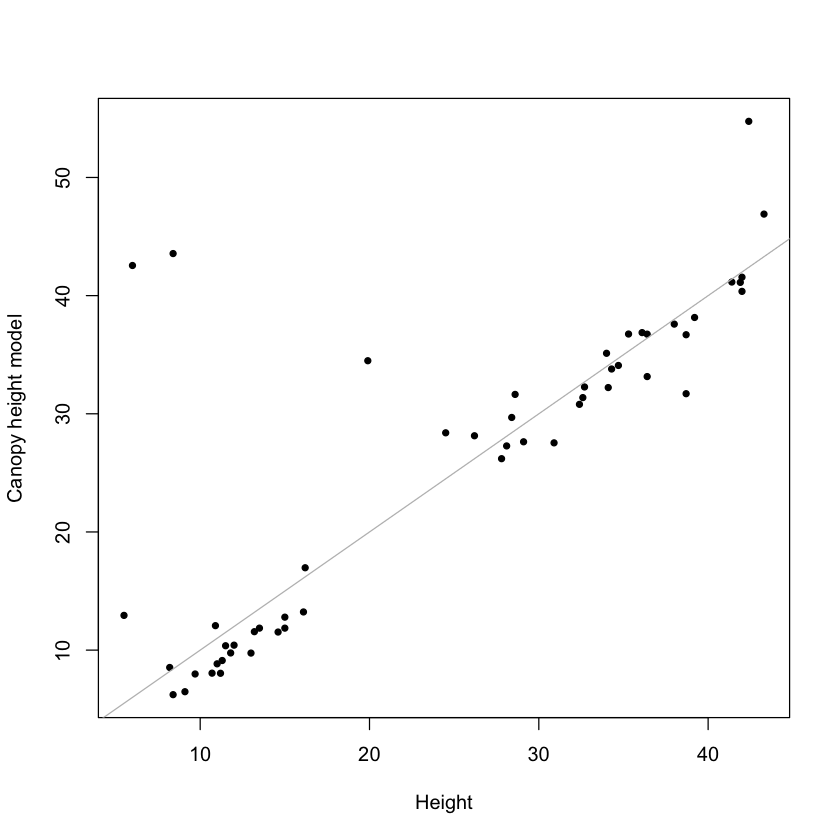

In [32]:
vegfil <- vegfil[which(vegfil$plantStatus=="Live"),]
filterCHM <- extract(chm, cbind(vegfil$adjEasting, vegfil$adjNorthing),
                         buffer=vegfil$adjCoordinateUncertainty+1, fun=max)
plot(filterCHM~vegfil$height, pch=20, xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [33]:
cor(filterCHM,vegfil$height)

[1] 0.8191121